# Descrição

Esse NotheBook tem como objetivo mostrar o processo de desenvolvimento com python para encontrar um modelo de machine learning que faz previsões sobre se uma pessoa sobrevive ou não ao titanic com base em uma fonte de dados que guarda informações dos passageiros sobreviventes e mortos no ocorrido.

# Importando Bibliotecas

In [1]:
from sklearn.model_selection import cross_val_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier as GBC
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV



/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Coletando e análisando dados

Coletando DataSet

In [2]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")

Análisando distribuição dos daods.

In [3]:
for c in df.columns:
    print("Valores nulos em",c,":",df[c].isna().sum())

Valores nulos em PassengerId : 0
Valores nulos em Survived : 0
Valores nulos em Pclass : 0
Valores nulos em Name : 0
Valores nulos em Sex : 0
Valores nulos em Age : 177
Valores nulos em SibSp : 0
Valores nulos em Parch : 0
Valores nulos em Ticket : 0
Valores nulos em Fare : 0
Valores nulos em Cabin : 687
Valores nulos em Embarked : 2


Vemos que há um valor alto de nulos em Age e Cabin, teremos que tratar isso depois.

Vamos olhar a distribuição númerica dos dados em cada coluna

Vamos primeiro plotar a distribuição de Age e Fare em vivos e mortos

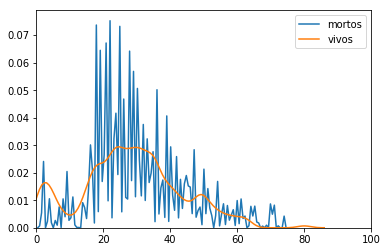

In [4]:
plt.Figure()
mortos = df[df["Survived"]==0]["Age"]
vivos = df[df["Survived"]==1]["Age"]
sns.kdeplot(mortos, bw=.2, label="mortos")
sns.kdeplot(vivos, bw=2, label="vivos")
plt.xlim([0,100])
plt.legend();

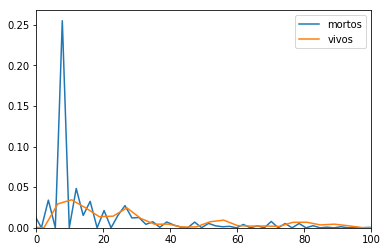

In [5]:
plt.Figure()
mortos = df[df["Survived"]==0]["Fare"]
vivos = df[df["Survived"]==1]["Fare"]
sns.kdeplot(mortos, bw=.2, label="mortos")
sns.kdeplot(vivos, bw=2, label="vivos")
plt.xlim([0,100])
plt.legend();

Parece haver uma relação entre idade e sobreviver ou não, mas não é tão evidente quanto a relação entre mortos e vivos com Fare, claramente há um pico de morte em Fare com valores menores que 20.

Vamos ver como essas distribuições se comportam quando colocamos elas de formas divididas com relação a outras colunas.

Análises de Age e Fare com base na coluna classificativa  Sex


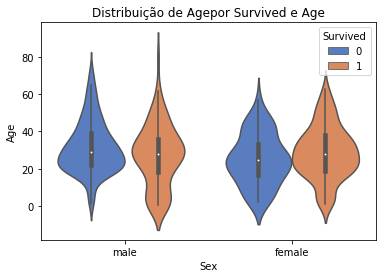

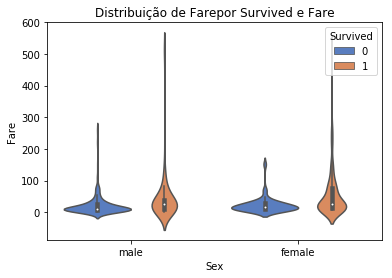

Análises de Age e Fare com base na coluna classificativa  Pclass


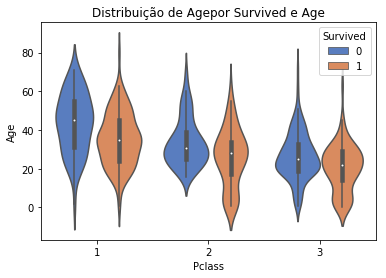

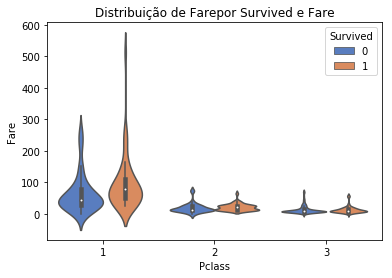

Análises de Age e Fare com base na coluna classificativa  SibSp


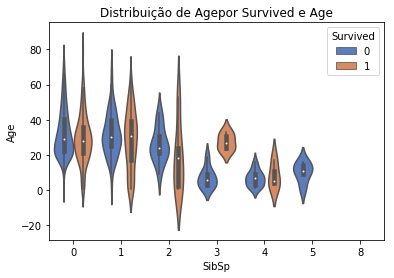

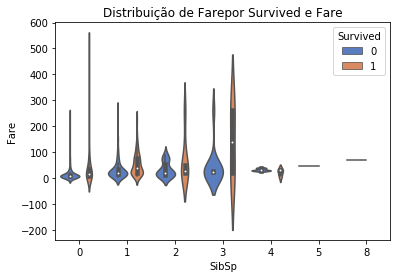

Análises de Age e Fare com base na coluna classificativa  Parch


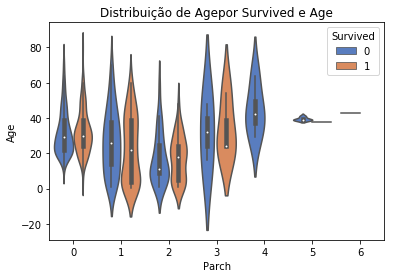

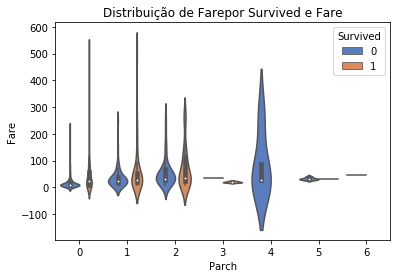

In [6]:

for c1 in ["Sex","Pclass","SibSp","Parch"]:
    print("Análises de Age e Fare com base na coluna classificativa ", c1)
    for c2 in ["Age","Fare"]:
        plt.Figure()
        sns.violinplot(x=c1, y=c2, hue="Survived",data=df, palette="muted").set_title("Distribuição de "+str(c2)+"por Survived e "+str(c2))
        plt.show()
        
        

Análises por colunas de classes:

1 - Sex: Não vejo uma correlção simples entre Sex,Survived e Age, mas podemos ver claramente que tanto para homens quanto para mulheres o Fare se concentra numa mesma facha para os mortos. Fare novamente mostrando alguma relação com sobrevivência.

2 - Pclass: Vemos que tanto para vivos quanto para mortos o valor de Age diminui de acordo com Pclass. Isso ocorre de forma mais intensa ainda com Fare onde os valores de Fare parecem se concentrar mais em um mesmo valor quanto mais alto é o Pclass. Note que os valores médios de Fare para os mortos se mostra menor que o valor médio de Fare para os vivos independente do Pclass.

3 - SibSp: O que é possível notar é que dependendo de qual SibSp olhamos grupos de idades diferentes tem mais chance de sobreviver ou morrer, além do fato que em SibSp = 5 não temos práticamente dados espalhados de vivos. O valor de Fare por outro lado continuou apresentando valores médios menores para mortos do que para vivos na maioria dos valores de SibSp.

4 - Parch: Algumas coisas continuaram se repetindo aqui como o comportamento médio de Fare, mas é interessante notar que pessoas com Parch maior que 4 apresentam distribuição de valores muito menos espalhada, isso é visto tanto no gráfico de Age quanto de Fare

Concluo que os dados são adequados para tentarmos montar um modelo em cima delas após um tratamento adequado nesse dataset.

# Tratamento de dados


Vamos começar eliminando a coluna PasseferID e focar nas demais

In [7]:
dados = df.drop(["PassengerId"],axis=1)
dados

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


**Coletando Títulos**

Na coluna Nome há Títulos de comos as pessoas eram referênciadas, provavelmente isso se correlaciona com o status da pessoa o que pode se correlacionar com as chances dela sobreviver em um desastre como o titânic.

In [8]:
dados["Title"] = dados["Name"].apply(lambda x: x.split(",")[1].split(".")[0])
for titulo in dados["Title"].unique():
    print(titulo)

 Mr
 Mrs
 Miss
 Master
 Don
 Rev
 Dr
 Mme
 Ms
 Major
 Lady
 Sir
 Mlle
 Col
 Capt
 the Countess
 Jonkheer


Faremos o seguinte. Os titulos mais importantes presentes no dataset parecem ser ' Mrs', ' Mr', ' Miss', ' Master', ' Dr',' Major',' Lady', ' Sir' então irei manter esses títulos e os demais chamarei de " Others" por aparentarem ser menos importante.

In [9]:
titles_taken = [' Mrs', ' Mr', ' Miss', ' Master', ' Dr',' Major',' Lady', ' Sir']
dados["Title"] = dados["Title"].apply(lambda x: x if x in titles_taken else " Others" ) 
for titulo in dados["Title"].unique():
    print(titulo)

 Mr
 Mrs
 Miss
 Master
 Others
 Dr
 Major
 Lady
 Sir


**IDADE**

A idade havia apresentado muitos valores nulos então precisamos lidar com isso.
Temos algumas alternativas:

1-Deletar todos valores nulos, o que impede que valores nulos atrapalhem o modelo final a aprender, mas muita informação provavelmente valiosa é perdida.

2-Substituir valores nulos por médias das colunas, o que garante que valores nulos não atrapalhem aprendizado caso não haja muitos outliers.

3-Substituir valores nulos por valores de linhas próximas, esse método pode ser útil quando linhas próximas tendem a ter comportamento similar, mas não parece ser nosso caso.

4-Substituir nulos por valor de mediana, parece uma boa ideia pois torna o resultado menos susetível a outliers.

Optei pela opção 4 e ainda farei isso de forma agrupada por Sex,Pclass e Title. Ou seja, dependendo da classificação da pessoa ela receberá uma mediana diferente em seu valor Null de idade.

Primeiramente, crio uma tabela de medianas agrupadas

In [10]:
grouped = dados.groupby(['Sex','Pclass','Title'])
grouped_median = grouped.median()
grouped_median = grouped_median.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median.head()

,Sex,Pclass,Title,Age
0,female,1,Dr,49.0
1,female,1,Lady,48.0
2,female,1,Miss,30.0
3,female,1,Mrs,41.5
4,female,1,Others,24.0


Agora preencho os valores nulls de acordo com esses agrupamentos

In [11]:
def fillNaWithMedian(row,group,median_column):
    
    if not np.isnan(row['Age']):
        return row['Age']
    
    age = group[group['Sex']==row['Sex']][group['Pclass']==row['Pclass']][group['Title']==row['Title']][median_column].tolist()[0]
    
    return age

dados["Age"] = dados.apply(lambda row: fillNaWithMedian(row,grouped_median,"Age") , axis = 1)
    
    
#checando se ainda há nulls
print(dados["Age"].isna().sum())
    
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0


Vamos agora extrair do Ticket preefixos.

**Tratando Cabin**

A coluna Cabin também apresentava muis valores nulls então vamos tratar esses valores subsituindo por "Desc" de desconhecido.
Uma vez que Cabin é classificativa não podemos usar um recurso como mediana para preencher valores vazios

In [12]:
dados["Cabin"] = dados["Cabin"].apply(lambda x: x if not pd.isnull(x) else "Desc" )
#checando se há nulls ainda
print(dados["Cabin"].isna().sum())

0


**Adquirindo preefixo de tickets**

Usar todos os tickets em nosso modelo parece complexo uma vez que são muitos valores. Vamos usar apenas o prefixo dos tickes para isso, parece uma solução melhor e caso o ticket não tenha prefixo prenchermos com "Other"

In [13]:
def getPrefix(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        try:#queremos so os prefixos de String
            int(ticket[0])
            return 'Other'
        except Exception:
            return ticket[0]
        
dados["Ticket"] = dados["Ticket"].apply(getPrefix)

**Convertendo valores de Sex**

Sex é uma coluna provavelmente importante mas seus valores são strings, vamos convertelos para ints com 0 e 1

In [14]:
dados["Sex"] = dados["Sex"].apply(lambda x: 0 if x=="male" else 1)

**Adquirindo Dummies**

Colunas classificativas que não podem ser transformadas em númericas vamos extrair seus valores dummies o que é muito melhor para a maioria dos modelos de Machine Learning entenderem.

Além disso vamos aproveitar e deletar a coluna Name que não usaremos mais

In [15]:

dados = dados.drop(["Name"],axis=1)

col_to_dummies = dados[["Cabin","Pclass","Embarked","Ticket","Title"]]
for c in col_to_dummies:
    dummies = pd.get_dummies(dados[c],prefix = c)
    dados.drop(c,axis=1,inplace = True)
    dados = pd.concat([dados,dummies],axis=1)
dados

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin_A10,Cabin_A14,Cabin_A16,Cabin_A19,...,Ticket_WEP,Title_ Dr,Title_ Lady,Title_ Major,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Others,Title_ Sir
0,0,0,22.0,1,0,7.2500,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,35.0,0,0,8.0500,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
887,1,1,19.0,0,0,30.0000,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
888,0,1,18.0,1,2,23.4500,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
889,1,0,26.0,0,0,30.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


**Normalizando Dados**

Vamos usar um StandardScaler para normalizar os dados, com o objetivo de dar destaque para elementos que fogem da média em distribuições pouco espalhadas.
Isso pode ser útil pois se um elemento apresenta um comportamento anormal e isso aparece acompanhado com maior número de mortos ou vivos o modelo pode capturar mais facil essa relação.

In [16]:

to_scalar = dados.drop("Survived",axis = 1)
survived = dados["Survived"].reset_index(drop=True)
sts = StandardScaler()
sts.fit(to_scalar)
x_scalar = sts.transform(to_scalar)

dados_scalar = pd.DataFrame(x_scalar)

# Procurar melhor modelo

**Encontrando algum modelo interessante**

Vamos testar com uso de cross validation o desempenho de alguns modelos

In [17]:
X = dados_scalar
y = survived


def test_type_model(type):
    test_model = type()

    test_model.fit(X,y)

    cv = KFold(n_splits = 10, shuffle = True)
    results = cross_validate(test_model, X, y, cv = cv)#roda o modelo 5 vezes
    acuracias = results['test_score']#kd um dos resultados de acuracia de kd um dos 5 testes

    std = acuracias.std()
    mean = acuracias.mean()
    mina = min(acuracias)
    maxa = max(acuracias)
    
    print("type: ",str(type).split(".")[3].split("'")[0])
    print("Accuracy range = [%.3f, %.3f]" % (mina, maxa), " mean = %.3f" % mean, " std = %.3f" % std )#intervalo de confiança

types = [RFC,GBC,LR,SVC]
for t in types:
    test_type_model(t)
    

type:  RandomForestClassifier
Accuracy range = [0.775, 0.888]  mean = 0.834  std = 0.035
type:  GradientBoostingClassifier
Accuracy range = [0.787, 0.889]  mean = 0.833  std = 0.032
type:  LogisticRegression
Accuracy range = [0.742, 0.876]  mean = 0.800  std = 0.043
type:  SVC
Accuracy range = [0.719, 0.843]  mean = 0.770  std = 0.036


Agora realizaremos uma exploração de hiperparâmetors em modelos de RandomForesClassifier e GradientBoostingClassifier que apresentaram os melhores resultados no teste inicial.
Nosso objetivo aqui é encontrar os melhores modelos dentro desses algoritmos

Vamos começar com RandomForest 

In [18]:

espaco_de_parametros = {
    "n_estimators": [10,50, 100],
    "max_depth" : [3,5,10,20,50,100],
    "min_samples_split": [2,32, 64, 128],
    "min_samples_leaf": [2,32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(RFC(),
                    espaco_de_parametros,
                    n_iter = 40,
                    cv = KFold(n_splits = 5, shuffle = True))


busca.fit(X, y)
resultados = pd.DataFrame(busca.cv_results_)
resultados.sort_values("mean_test_score", ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.131197,0.000430,0.007856,0.000051,50,2,2,100,gini,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.826816,0.808989,0.825843,0.853933,0.814607,0.826037,0.015493,1
21,0.029233,0.000571,0.003466,0.000034,10,2,2,5,gini,"{'n_estimators': 10, 'min_samples_split': 2, '...",0.821229,0.814607,0.797753,0.803371,0.831461,0.813684,0.012116,2
32,0.128388,0.001734,0.007810,0.000176,50,32,2,100,entropy,"{'n_estimators': 50, 'min_samples_split': 32, ...",0.815642,0.808989,0.814607,0.814607,0.797753,0.810320,0.006705,3


Encontramos o melhor modelo de RandomForest na primeira linha da tabela.

Vamos analisar a correlação dos parâmetros com o score medio

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


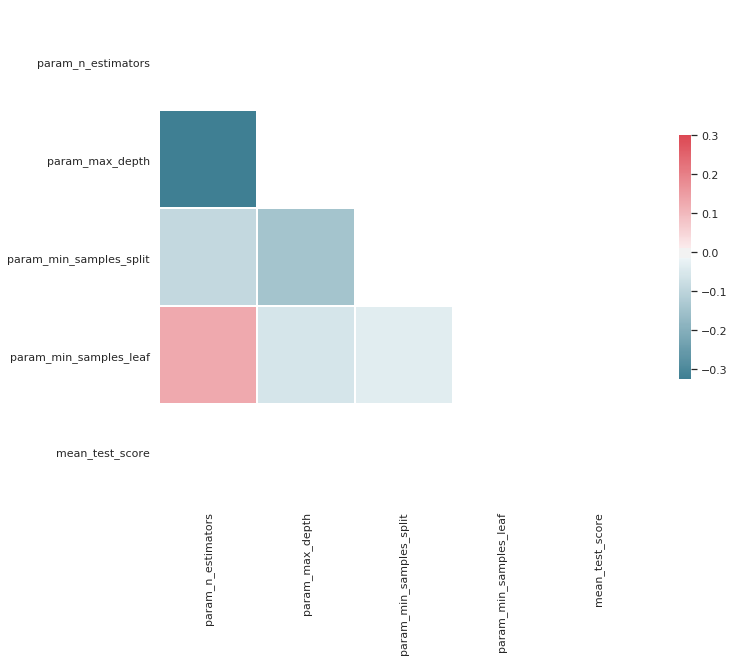

In [19]:
sns.set(style="white")

to_use = resultados[["param_n_estimators","param_max_depth" ,"param_min_samples_split","param_min_samples_leaf","mean_test_score"]]

for c in to_use:
    to_use[c] = to_use[c].apply(int)

corr = to_use.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))


cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Parece que nenhuma das váriaveis apresenta uma relação maior com a media de score em relação as demais, todas provavelmente contribuem de forma aproximadamente igual para o resultado.

Vamos realizar o mesmo processo com o GadientBoosting agora.

In [20]:


espaco_de_parametros = {
    "loss":["deviance", "exponential"],
    "learning_rate":[0.001,0.01,0.1,0.3],
    "n_estimators": [50,100,200],
    "min_samples_split":[2,5],
    "min_samples_leaf":[1,3]
}

busca = RandomizedSearchCV(GBC(),
                    espaco_de_parametros, 
                    n_iter = 40,
                    cv = KFold(n_splits = 5, shuffle = True))

busca.fit(X, y)
resultados = pd.DataFrame(busca.cv_results_)
resultados.sort_values("mean_test_score", ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_loss,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.13049,0.001275,0.002512,0.000046,50,5,1,deviance,0.3,"{'n_estimators': 50, 'min_samples_split': 5, '...",0.810056,0.831461,0.831461,0.859551,0.837079,0.833921,0.015802,1
33,0.53954,0.006689,0.003008,0.000070,200,5,1,exponential,0.1,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.787709,0.848315,0.837079,0.853933,0.837079,0.832823,0.023482,2
9,0.26049,0.006774,0.002835,0.000294,100,5,1,deviance,0.3,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.798883,0.831461,0.848315,0.853933,0.820225,0.830563,0.019862,3


O melhor resultado de Gradient Boosting está na primeira linha da tabela.


Vamos analisar a correlação que nem da última vez.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


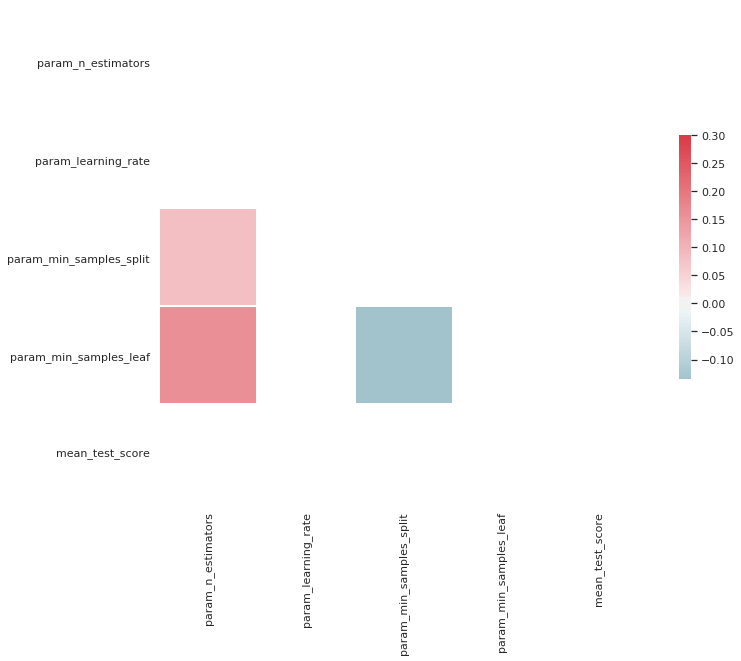

In [21]:
sns.set(style="white")

to_use = resultados[["param_n_estimators","param_learning_rate" ,"param_min_samples_split","param_min_samples_leaf","mean_test_score"]]

for c in to_use:
    to_use[c] = to_use[c].apply(int)

corr = to_use.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))


cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Aparentemente novamente nenhuma váriavel se sobressai na contribuição pro resultado em relação as demais.

**Nested cross validation**

Irei escolher o GradientBoostingClassifier por ele ter apresentado um resultado melhor em seu melhor modelo.

Agora realizarei uma operação de nested cross validation para validar o resultado.

In [22]:

scores = cross_val_score(busca, X, y, cv = KFold(n_splits=5, shuffle=True))

std = scores.std()
mean = scores.mean()
mina = min(scores)
maxa = max(scores)
    

print("Score range = [%.3f, %.3f]" % (mina, maxa), " mean = %.3f" % mean, " std = %.3f" % std )#intervalo de confiança


Score range = [0.798, 0.832]  mean = 0.824  std = 0.013


Vamos treinar um modelo com os melhores parâmetros que encontramos e avaliar seu resultado

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

final_model = busca.best_estimator_

final_model.fit(X_train,y_train)

previsoes = final_model.predict(X_test)

for linha in classification_report(y_test,previsoes).split("\n"):
    print(linha)




              precision    recall  f1-score   support

           0       0.92      0.88      0.90       123
           1       0.76      0.84      0.80        56

    accuracy                           0.87       179
   macro avg       0.84      0.86      0.85       179
weighted avg       0.87      0.87      0.87       179



Tivemos um desempenho de accuracy interessante, nosso f1-score foi alto para prever mortos.
Nosso modelo final está suficientemente bom para o que eu procurava atingir aqui.